In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jaxopt import ScipyMinimize
import passenger

In [2]:
prefixes = ["8a", "9a", "11a"]
output_prefix = "chigy_lc"
nt_base_start = 336
chigy_stop_trimmed = passenger.CHIGY_LC_STOP_TRIMMED
chigy_codonable = chigy_stop_trimmed[:321]
output_dir = "output/passenger/"
output_path_prefix = output_dir+output_prefix

problem_positions = np.array([295, 306, 307, 319, 321])

In [3]:
fivemers = pd.read_csv('output/passenger/fivemers.csv')
fivemers.columns = ['Fivemer']
mut8a = pd.read_csv('output/passenger/8a_mut_freq.csv')
mut9a = pd.read_csv('output/passenger/9a_mut_freq.csv')
mut11a = pd.read_csv('output/passenger/11a_mut_freq.csv')
df = pd.concat([fivemers, mut8a, mut9a, mut11a], axis=1)

mutability = pd.read_csv('../nextflow/data/mutability/MK_RS5NF_mutability.csv', sep=' ')
mutability_series = mutability.set_index('Fivemer')['Mutability']

df['Mutability'] = df['Fivemer'].map(mutability_series)

# set a lower threshold of 1e-6 for all mut_freq columns
df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']] = df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']].clip(lower=1e-5)
# get the min of each _mut_freq column
df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']].min(axis=0)


8a_mut_freq     0.000010
9a_mut_freq     0.000054
11a_mut_freq    0.000033
dtype: float64

In [4]:
assert passenger.matches_RGYW("AAGCT") == True


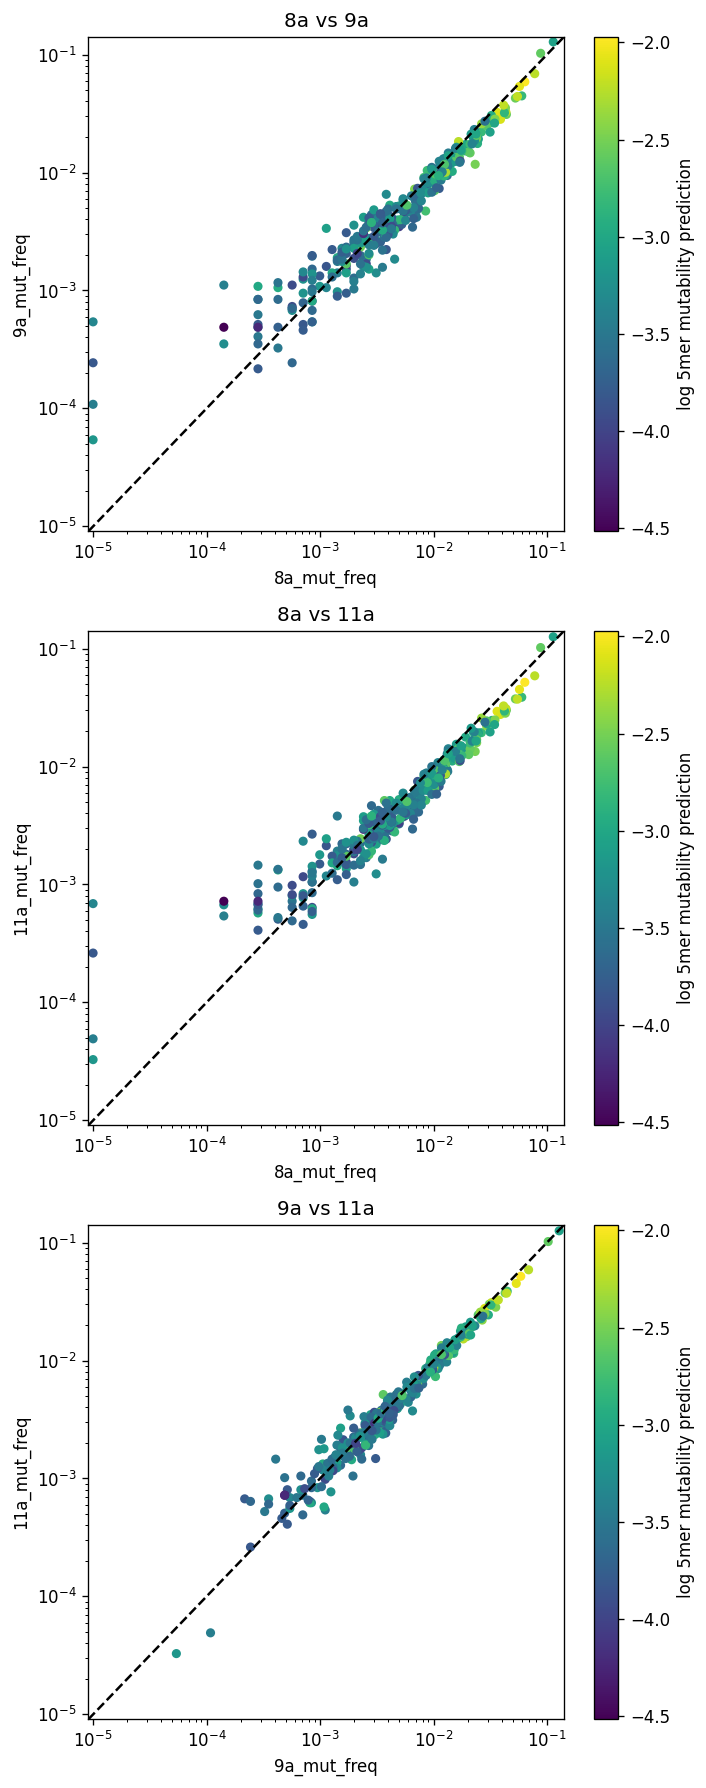

In [5]:
cbar_title = 'log 5mer mutability prediction'
df[cbar_title] = np.log10(df['Mutability'])

min_limit = min(df['8a_mut_freq'].min(), df['9a_mut_freq'].min(), df['11a_mut_freq'].min())/1.1
max_limit = max(df['8a_mut_freq'].max(), df['9a_mut_freq'].max(), df['11a_mut_freq'].max())*1.1

def set_limits_and_styles(ax, title, min_limit, max_limit):
    ax.set_title(title)
    ax.set_xlim(min_limit, max_limit)
    ax.set_ylim(min_limit, max_limit)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([min_limit, max_limit], [min_limit, max_limit], 'k--')  # Add x=y line


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 15))

# Plot each scatter plot
df.plot.scatter(x='8a_mut_freq', y='9a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=axs[0])
set_limits_and_styles(axs[0], '8a vs 9a', min_limit, max_limit)

df.plot.scatter(x='8a_mut_freq', y='11a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=axs[1])
set_limits_and_styles(axs[1], '8a vs 11a', min_limit, max_limit)

df.plot.scatter(x='9a_mut_freq', y='11a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=axs[2])
set_limits_and_styles(axs[2], '9a vs 11a', min_limit, max_limit)

plt.tight_layout()
plt.show()


Text(0, 0.5, '11a mutation rate per site')

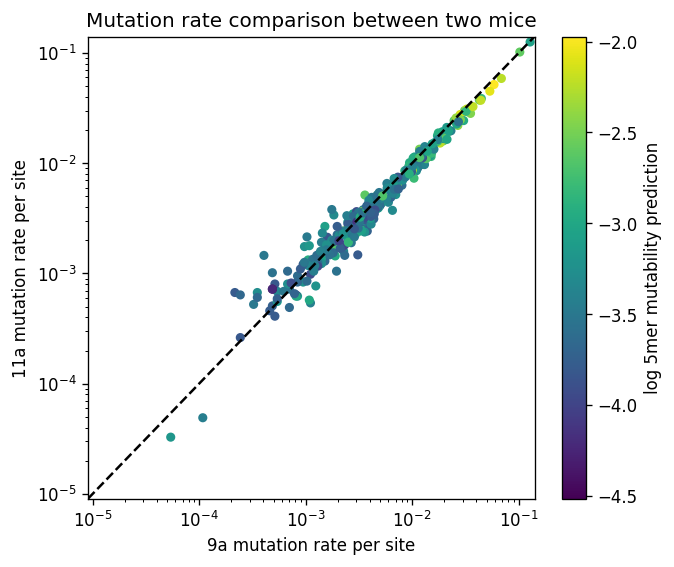

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

df.plot.scatter(x='9a_mut_freq', y='11a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=ax)
set_limits_and_styles(ax, '9a vs 11a', min_limit, max_limit)
plt.title("Mutation rate comparison between two mice")
plt.xlabel("9a mutation rate per site")
plt.ylabel("11a mutation rate per site")
# fig.savefig('passenger_9a_vs_11a.svg', format='svg', dpi=300)

## Combining information across the three experiments

### Substitution

Because the substitution matrix is simply a categorical on bases conditioned on a substitution, we don't have to worry about varying mutation load between the data sets.

In [7]:
pseudocount = 0.5

by_base_dfs = {}
for prefix in prefixes:
    by_base_dfs[prefix] = pd.read_csv(f'{output_dir}/{prefix}_counts_by_base.csv', index_col=0)
    by_base_dfs[prefix] = by_base_dfs[prefix].replace(-1, float("nan"))
    assert by_base_dfs[prefix].min().min() >= 0

# total these dfs
by_base_df = sum(df for df in by_base_dfs.values())

by_base_df += pseudocount
# replace all nans by 0
by_base_df = by_base_df.fillna(0)
by_base_df = by_base_df.div(by_base_df.sum(axis=1), axis=0)
by_base_df.to_csv(output_path_prefix+"_substitution.csv")
by_base_df

,A,C,G,T
0,0.411765,0.294118,0.000000,0.294118
1,0.000000,0.060465,0.265116,0.674419
2,0.529412,0.000000,0.281046,0.189542
3,0.000000,0.063209,0.257699,0.679092
4,0.306811,0.494268,0.198921,0.000000
...,...,...,...,...
317,0.000000,0.134990,0.578688,0.286322
318,0.000000,0.223619,0.592127,0.184254
319,0.000000,0.013225,0.078101,0.908674
320,0.000000,0.090909,0.636364,0.272727


### Mutability

Let $i$ index the sites, and $j$ represent the experiment.
We will use the notation:

* $n_{ij}$: the number of mutations observed at site $i$ in experiment $j$
* $r_i$: the rate of mutation at site $i$
* $\lambda_j$: the Poisson offset for experiment $j$ representing the length of the period of affinity maturation
* $s_j$: the sequencing depth of experiment $j$

We will model

$$
n_{ij} \sim \operatorname{Pois}(r_i \lambda_j s_j)
$$

The log likelihood for this model across all sites and experiments will be 

$$
C + \sum_{i,j} \left[n_{ij} \log(r_i \lambda_j s_j) - r_i \lambda_j s_j \right]
$$

In [8]:
by_site_df = pd.DataFrame({name: df.sum(axis=1, skipna=True) for name, df in by_base_dfs.items()})
by_site_df

,8a,9a,11a
0,0.0,4.0,3.0
1,2.0,15.0,89.0
2,1.0,41.0,33.0
3,32.0,68.0,207.0
4,62.0,289.0,389.0
...,...,...,...
317,222.0,812.0,1198.0
318,78.0,347.0,488.0
319,800.0,4723.0,7670.0
320,0.0,2.0,2.0


In [9]:
read_counts = jnp.array([7043, 36903, 61047])
site_count = by_site_df.shape[0]
experiment_count = by_site_df.shape[1]

def neg_log_likelihood(params, n_ij, s_j):
    log_r_i, log_lambda_j = params[:site_count], params[site_count:]
    lambda_j = jnp.exp(log_lambda_j)
    r_i = jax.nn.softmax(log_r_i)
    expected = r_i[:, None] * lambda_j[None, :] * s_j[None, :]
    ll = n_ij * jnp.log(expected) - expected
    return -jnp.sum(ll)

n_ij = jnp.array(by_site_df)
initial_params = jnp.log(jnp.ones(site_count + experiment_count))

neg_log_likelihood(initial_params, n_ij, read_counts)

Array(-1200060.03571553, dtype=float64)

In [10]:
# Set up the optimizer
optimizer = ScipyMinimize(fun=neg_log_likelihood, method='BFGS')
result = optimizer.run(initial_params, n_ij=n_ij, s_j=read_counts)

# Extract the optimized parameters
opt_params = result.params
r_i_opt = jax.nn.softmax(opt_params[:site_count])
lambda_j_opt = jnp.exp(opt_params[site_count:])

print("Optimized lambda_j:", lambda_j_opt)
opt_likelihood = neg_log_likelihood(opt_params, n_ij, read_counts)

df["fit_rate"] = r_i_opt

Optimized lambda_j: [2.97202897 2.64664119 2.4279162 ]


We see good concordance with just the normalized frequency using the 11a data:

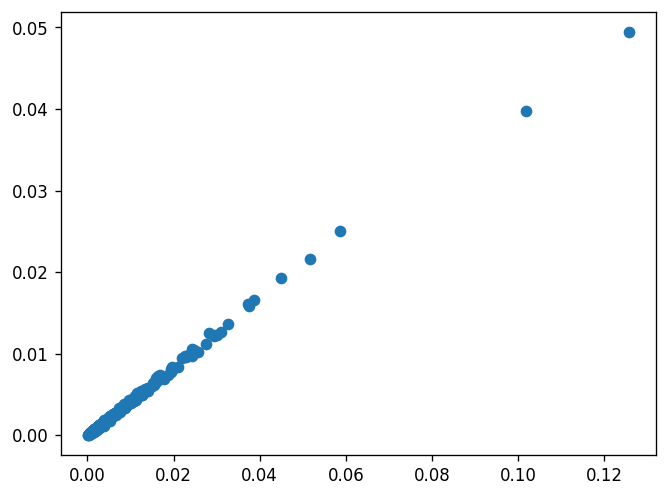

In [11]:
plt.scatter(df["11a_mut_freq"], df["fit_rate"])

## Correcting problem positions

### Substitution probabilities

In [12]:
fivemer_subs = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=' ')

fivemer_subs.set_index('Fivemer', inplace=True)

fivemer_subs = fivemer_subs.loc[df['Fivemer']].reset_index()

fivemer_subs

,Fivemer,A,C,G,T
0,NNGAC,0.809627,0.080776,0.000000,0.109597
1,NGACA,0.000000,0.190511,0.604532,0.204957
2,GACAT,0.105263,0.000000,0.263158,0.631579
3,ACATT,0.000000,0.105263,0.447368,0.447368
4,CATTG,0.240000,0.520000,0.240000,0.000000
...,...,...,...,...,...
317,ATAAA,0.000000,0.118519,0.585185,0.296296
318,TAAAA,0.000000,0.170259,0.721983,0.107759
319,AAAAC,0.000000,0.191268,0.704782,0.103950
320,AAACN,0.000000,0.131992,0.617877,0.250131


In [13]:
# for every index in problem_positions, get the A, C, G, T columns from fivemer_subs and replace the corresponding columns of df with them
for i in problem_positions:
    by_base_df.iloc[i, :] = fivemer_subs.iloc[i, 1:]
    
by_base_df

,A,C,G,T
0,0.411765,0.294118,0.000000,0.294118
1,0.000000,0.060465,0.265116,0.674419
2,0.529412,0.000000,0.281046,0.189542
3,0.000000,0.063209,0.257699,0.679092
4,0.306811,0.494268,0.198921,0.000000
...,...,...,...,...
317,0.000000,0.134990,0.578688,0.286322
318,0.000000,0.223619,0.592127,0.184254
319,0.000000,0.191268,0.704782,0.103950
320,0.000000,0.090909,0.636364,0.272727


### Mutability

In [14]:
# set the rate of the problematic positions to nan
df.loc[problem_positions, "fit_rate"] = np.nan
# sum of df["fit_rate"], ignoring nan values
fit_rate_sum = df["fit_rate"].sum(skipna=True)
df["rate"] = df["fit_rate"]/fit_rate_sum
df["normed_s5f"] = df["Mutability"] / sum(df["Mutability"])

df.loc[problem_positions, "rate"] = df.loc[problem_positions, "normed_s5f"]

df

,Fivemer,8a_mut_freq,9a_mut_freq,11a_mut_freq,Mutability,log 5mer mutability prediction,fit_rate,rate,normed_s5f
0,NNGAC,0.000010,0.000108,0.000049,0.000367,-3.435332,0.000026,0.000030,0.001264
1,NGACA,0.000284,0.000407,0.001459,0.000321,-3.493627,0.000397,0.000450,0.001106
2,GACAT,0.000142,0.001111,0.000541,0.000384,-3.415452,0.000281,0.000319,0.001324
3,ACATT,0.004544,0.001843,0.003392,0.000493,-3.307406,0.001151,0.001304,0.001698
4,CATTG,0.008803,0.007832,0.006375,0.000496,-3.304830,0.002773,0.003143,0.001708
...,...,...,...,...,...,...,...,...,...
317,ATAAA,0.031521,0.022006,0.019633,0.000867,-3.062087,0.008365,0.009481,0.002986
318,TAAAA,0.011075,0.009404,0.007998,0.001240,-2.906640,0.003422,0.003878,0.004272
319,AAAAC,0.113588,0.127998,0.125699,0.000865,-3.063223,NaN,0.002979,0.002979
320,AAACN,0.000010,0.000054,0.000033,0.000656,-3.183266,0.000015,0.000017,0.002259


In [15]:
df = pd.concat([df, by_base_df * df["rate"].values[:, None]], axis=1)
df.index = df.index + nt_base_start
df

,Fivemer,8a_mut_freq,9a_mut_freq,11a_mut_freq,Mutability,log 5mer mutability prediction,fit_rate,rate,normed_s5f,A,C,G,T
336,NNGAC,0.000010,0.000108,0.000049,0.000367,-3.435332,0.000026,0.000030,0.001264,0.000012,0.000009,0.000000,0.000009
337,NGACA,0.000284,0.000407,0.001459,0.000321,-3.493627,0.000397,0.000450,0.001106,0.000000,0.000027,0.000119,0.000304
338,GACAT,0.000142,0.001111,0.000541,0.000384,-3.415452,0.000281,0.000319,0.001324,0.000169,0.000000,0.000090,0.000060
339,ACATT,0.004544,0.001843,0.003392,0.000493,-3.307406,0.001151,0.001304,0.001698,0.000000,0.000082,0.000336,0.000886
340,CATTG,0.008803,0.007832,0.006375,0.000496,-3.304830,0.002773,0.003143,0.001708,0.000964,0.001554,0.000625,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,ATAAA,0.031521,0.022006,0.019633,0.000867,-3.062087,0.008365,0.009481,0.002986,0.000000,0.001280,0.005486,0.002715
654,TAAAA,0.011075,0.009404,0.007998,0.001240,-2.906640,0.003422,0.003878,0.004272,0.000000,0.000867,0.002296,0.000715
655,AAAAC,0.113588,0.127998,0.125699,0.000865,-3.063223,NaN,0.002979,0.002979,0.000000,0.000570,0.002099,0.000310
656,AAACN,0.000010,0.000054,0.000033,0.000656,-3.183266,0.000015,0.000017,0.002259,0.000000,0.000002,0.000011,0.000005


In [16]:
df.to_csv(f"{output_path_prefix}_mutation_rates_nt.csv", columns=["Fivemer", "A", "C", "G", "T"])

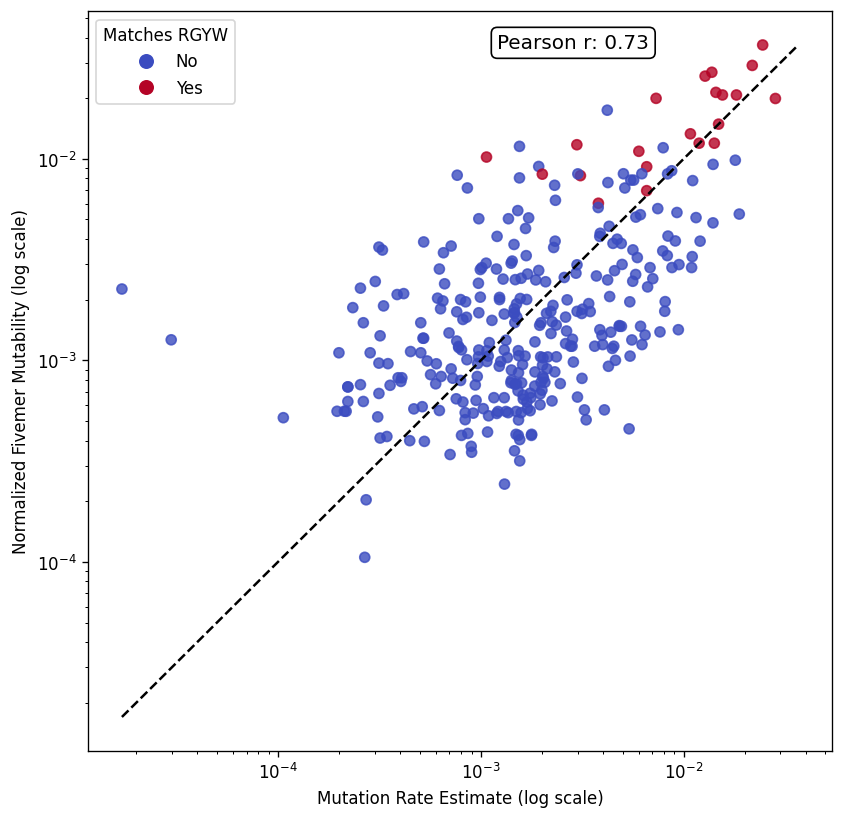

In [17]:
# Apply the matches_RGYW function to the 'Fivemer' column
df['matches_RGYW'] = df['Fivemer'].apply(passenger.matches_RGYW)

passenger.plot_mutation_rate_vs_normed_s5f(df)